In [2]:
import pandas as pd
import xarray as xr
import os
import numpy as np
from utils.analysis import *
from utils.constants import *
from utils.paths import *
from utils.extremes import *
from utils.plotting import *
from utils.regression import *
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, spearmanr, pearsonr, wilcoxon, linregress
from statsmodels.tools.tools import add_constant
from scipy.interpolate import UnivariateSpline
from matplotlib.colors import BoundaryNorm
import itertools as it
from tqdm import tqdm


self = Plotter('heat_wave')
self.prefix = 'percity_per_pixel'
self.extent = Setup().extent
self.name = Setup().name # veg data
self.heat_wave_thres = Setup().heat_wave_thres
self.hot_and_dry_thres = Setup().hot_and_dry_thres

use_gap_to_optimalT = False
if use_gap_to_optimalT:
    folder = 'gap_to_optimalT'
else:
    folder = 'optimalT'

no_crop = True
if no_crop:
    suffix = '_nocrop'
else:
    suffix = ''

# Uncomment this to re-run
# self.get_city_summary(no_crop)
# self.get_city_summary_by_event(no_crop)

In [11]:
""" By each season and whole U.S., the urban-rural difference in sign and magnitude.
"""
data = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'{self.prefix}_{self.extent}_{self.name}_{self.heat_wave_thres}_{self.hot_and_dry_thres}_{self.extreme}_city_average{suffix}.csv'),
                   index_col = [0, 1, 2], header = [0, 1])
data.columns = data.columns.reorder_levels([1, 0])
data = data.stack()
data.index.names = ['season', 'use', 'fid', 'stat']
data['frac_pos_diff'] = data['frac_pos_urban'] - data['frac_pos_rural']
data['median_abs_diff'] = data['median_abs_urban'] - data['median_abs_rural']
data['median_abs_diff, pos'] = data['median_abs_urban, pos'] - data['median_abs_rural, pos']
data['median_abs_diff, neg'] = data['median_abs_urban, neg'] - data['median_abs_rural, neg']
data = data.loc[:, ['frac_pos_diff', 'frac_pos_pval', 'median_abs_diff', 'median_abs_pval', 'median_abs_diff, pos', 'median_abs_pval, pos', 'median_abs_diff, neg', 'median_abs_pval, neg']]
data = data.reset_index()


rcParams['font.size'] = 6
rcParams['axes.titlesize'] = 6
lab = 'abcdefghijklmn'
clist = ['#0000ff', '#87cefa', '#ff0000', '#e69b00']

fig, axes = plt.subplots(2, 2, figsize = (6.5, 6.5), sharex = False, sharey = False)
for i, varname in enumerate(['frac_pos_diff', 'median_abs_diff', 'median_abs_diff, pos', 'median_abs_diff, neg']):
    ax = axes.flat[i]
    ax.axhline(0., ls = ':', lw = 0.5)

    g = sns.boxplot(ax = ax, x = 'stat', hue = 'season', y = varname, data = data, hue_order = ['DJF', 'MAM', 'JJA', 'SON'],
                    order = ['Resistance', 'Recovery'], palette = clist, whis = (5, 95), fliersize = 2, linewidth = 0.5)

    if i == 3:
        sns.move_legend(g, 'lower left', bbox_to_anchor = (0, -0.2), ncol = 4, title = None)
    else:
        ax.legend([],[], frameon=False)

    ax.text(0.05, 0.9, lab[i], transform = ax.transAxes, fontweight = 'bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

    # calculate the significance of difference between the urban and rural metrics
    diff = pd.DataFrame(np.nan,
                        index = pd.MultiIndex.from_product([['Resistance', 'Recovery'], ['DJF', 'MAM', 'JJA', 'SON']]),
                        columns = ['daymet', 'topowx', 'yyz'])
    pvalues = pd.DataFrame(np.nan,
                           index = pd.MultiIndex.from_product([['Resistance', 'Recovery'], ['DJF', 'MAM', 'JJA', 'SON']]),
                           columns = ['daymet', 'topowx', 'yyz'])
    for stat, season, use in it.product(['Resistance', 'Recovery'], ['DJF', 'MAM', 'JJA', 'SON'], ['daymet', 'topowx', 'yyz']):
        diff.loc[(stat, season), use] = data.loc[(data['stat'] == stat) & (data['season'] == season) & (data['use'] == use), varname].mean()
        pvalues.loc[(stat, season), use] = wilcoxon(data.loc[(data['stat'] == stat) & (data['season'] == season) & (data['use'] == use), varname]).pvalue
    diff = diff.median(axis = 1).unstack()
    pvalues = pvalues.median(axis = 1).unstack()

    if i == 0:
        yloc = 0.25
    else:
        yloc = -0.44
    for j, stat in enumerate(['Resistance','Recovery']):
        for k, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
            mid = diff.loc[stat, season]
            pval = pvalues.loc[stat, season]

            if pval <= 0.05:
                kwargs = {'bbox': dict(facecolor = 'none', edgecolor = 'k', pad = 1, lw = 0.5)}
            else:
                kwargs = {}
            ax.text(j - 0.4 + 0.2 * k, yloc + 0.05 * np.mod(k, 2), f'{mid:.3f}', **kwargs)

    if i == 0:
        ax.set_title('$\Delta$Fraction positive')
    elif i == 1:
        ax.set_title('$\Delta$Absolute value')
    elif i == 2:
        ax.set_title('$\Delta$Absolute value, positive')
    elif i == 3:
        ax.set_title('$\Delta$Absolute value, negative')
    
    if i == 0:
        ax.set_ylim([-0.15, 0.42])
    else:
        ax.set_ylim([-0.48, 0.31])

fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
fig.savefig(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_spatial_avg_summary_{fix}_{self.extreme}_fig1{suffix}.png'), dpi = 600., bbox_inches = 'tight', facecolor = 'w')
plt.close(fig)

In [19]:
""" Urban-rural differences separately for the eastern and western U.S."""
data = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'{self.prefix}_{self.extent}_{self.name}_{self.heat_wave_thres}_{self.hot_and_dry_thres}_{self.extreme}_city_average{suffix}.csv'),
                   index_col = [0, 1, 2], header = [0, 1])
data.columns = data.columns.reorder_levels([1, 0])
data = data.stack()
data.index.names = ['season', 'use', 'fid', 'stat']
data['frac_pos_diff'] = data['frac_pos_urban'] - data['frac_pos_rural']
data['median_abs_diff'] = data['median_abs_urban'] - data['median_abs_rural']
data['median_abs_diff, pos'] = data['median_abs_urban, pos'] - data['median_abs_rural, pos']
data['median_abs_diff, neg'] = data['median_abs_urban, neg'] - data['median_abs_rural, neg']
data = data.loc[:, ['frac_pos_diff', 'frac_pos_pval', 'median_abs_diff', 'median_abs_pval', 'median_abs_diff, pos', 'median_abs_pval, pos', 'median_abs_diff, neg', 'median_abs_pval, neg']]
data = data.reset_index()

diff_collect = pd.DataFrame(np.nan, index = pd.MultiIndex.from_product([['frac_pos_diff', 'median_abs_diff'], ['DJF', 'MAM', 'JJA', 'SON']]), 
                             columns = pd.MultiIndex.from_product([['Resistance', 'Recovery'], ['East', 'West'], ['diff', 'pval']]))
for varname, season, stat, loc in it.product(['frac_pos_diff', 'median_abs_diff'], ['DJF', 'MAM', 'JJA', 'SON'], ['Resistance', 'Recovery'], ['East', 'West']):
    subset = data.loc[(data['season'] == season) & (data['stat'] == stat), ['fid', 'use', varname]]

    if loc == 'West':
        subset = subset.loc[subset['fid'].isin(modis_luc_city_groups['West']), ['use', varname]]
    else:
        subset = subset.loc[~subset['fid'].isin(modis_luc_city_groups['West']), ['use', varname]]

    diff = [None] * 3
    pval = [None] * 3
    for i, use in enumerate(['daymet', 'topowx', 'yyz']):
        temp = subset.loc[subset['use'] == use, varname]
        diff[i] = np.median(temp)
        _, pval[i] = wilcoxon(temp)

    diff = np.median(diff)
    pval = np.median(pval)

    diff_collect.loc[(varname, season), (stat, loc, 'diff')] = diff
    diff_collect.loc[(varname, season), (stat, loc, 'pval')] = pval
print(diff_collect)
fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
diff_collect.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_spatial_avg_summary_{fix}_{self.extreme}_fig1{suffix}.csv'))

                    Resistance                                    Recovery  \
                          East                    West                East   
                          diff          pval      diff      pval      diff   
frac_pos_diff   DJF   0.024453  2.911444e-04  0.012372  0.346550  0.022746   
                MAM  -0.001959  9.303114e-01  0.010589  0.670525 -0.006108   
                JJA  -0.012080  4.843873e-03  0.023789  0.048279 -0.010363   
                SON  -0.003429  6.628169e-02  0.000892  0.579842  0.002805   
median_abs_diff DJF  -0.010672  1.140978e-02 -0.001488  0.932281 -0.014603   
                MAM  -0.019170  1.677879e-05 -0.010794  0.670525 -0.026474   
                JJA  -0.037936  1.294652e-10 -0.010779  0.141518 -0.034194   
                SON  -0.031619  1.793103e-09  0.000122  0.701881 -0.025166   

                                                       
                                       West            
                             

In [16]:
os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary')

'/gpfs/alpine/cli146/proj-shared/ywo/URBAN_LDRD/output/measures/regression_per_pixel/summary'

In [4]:
""" Plot the city-level average in the per pixel resistance and recovery. 
    Plot the urban-rural differences. 
    As maps.
"""
data = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'{self.prefix}_{self.extent}_{self.name}_{self.heat_wave_thres}_{self.hot_and_dry_thres}_{self.extreme}_city_average{suffix}.csv'),
                   index_col = [0, 1, 2], header = [0, 1])

# draw
cmap = cmap_div() # sns.diverging_palette(10, 240, s = 100, l = 45, as_cmap = True)
lab = 'abcdefghijklmnopqrstuvwxyz'
rcParams['font.size'] = 5
rcParams['axes.titlesize'] = 5

map_args = {
    'diff_frac_pos': {'norm': BoundaryNorm([-0.09, -0.06, -0.03, -0.015, 0, 0.015, 0.03, 0.06, 0.09], 256, extend = 'both'), 'cmap': cmap},
    'diff_median_abs': {'norm': BoundaryNorm([-0.09, -0.06, -0.03, -0.015, 0, 0.015, 0.03, 0.06, 0.09], 256, extend = 'both'), 'cmap': cmap},
    'abs' : {'norm': BoundaryNorm([-0.24, -0.12, -0.06, 0, 0.06, 0.12, 0.24], 256, extend = 'both'), 'cmap': cmap}
}
bar_args = {'color': ['#313695', '#4575b4', '#a50026', '#d73027']}

for f in range(2):
    fig, axes = plt.subplots(4, 4, figsize = (6.5, 5.5), subplot_kw = {'projection': ccrs.AlbersEqualArea(central_longitude = -100, central_latitude = 35)})
    fig.subplots_adjust(hspace = 0.01, wspace = 0.01)
    for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        if f == 0:
            mag = map_args['abs']
            for j, name in enumerate(['urban', 'rural']):
                for k, target in enumerate(['Resistance', 'Recovery']):
                    ax = axes[k*2 + j, i]
                    temp = data.loc[season, (target, f'median_{name}')].groupby('fid').median()
                    pval = data.loc[season, (target, f'median_{name}_pval')].groupby('fid').median()
                    temp = pd.DataFrame({'value' : temp.values, 'pvalue': pval.values <= 0.05})
                    map = MapOfColors('point', temp)
                    cf = map.plot(ax = ax, inset_bar = True, map_args = mag, bar_args = bar_args, point_scale = 0.2)

                    if (j == 0) & (k == 0):
                        ax.set_title(season)
                    if i == 0:
                        ax.text(-0.1, 0.5, f'{target} {name}', rotation = 90, verticalalignment = 'center', transform = ax.transAxes)
                    if (i == 3) & (k == 0):
                        cax = fig.add_axes([0.92, 0.54 - 0.4 * j, 0.01, 0.3])
                        plt.colorbar(cf, cax = cax, orientation = 'vertical')

                    if name == 'rural':
                        # rural: Pearson correlation with the urban results
                        xtemp = data.loc[season, (target, f'median_abs_urban')]
                        ytemp = data.loc[season, (target, f'median_abs_rural')]
                        rho = [None] * 3
                        pval = [None] * 3
                        for m, use in enumerate(['daymet', 'topowx', 'yyz']):
                            rho[m], pval[m] = pearsonr(xtemp.loc[xtemp.index.get_level_values('use') == use].values, 
                                                       ytemp.loc[ytemp.index.get_level_values('use') == use].values)
                        rho = np.median(rho)
                        pval = np.median(pval)
                        if pval <= 0.05:
                            fontweight = 'bold'
                        else:
                            fontweight = 'normal'
                        ax.text(0.6, 0.84, f'$r=${rho:.2g}', fontweight = fontweight, transform = ax.transAxes)
                    ax.text(0.02, 0.91, lab[j*4 + k*8 + i], fontweight = 'bold', transform = ax.transAxes)
        else:
            for j, name in enumerate(['frac_pos', 'median_abs']):
                for k, target in enumerate(['Resistance', 'Recovery']):
                    ax = axes[k + j*2, i]
                    temp = data.loc[season, (target, f'{name}_urban')].groupby('fid').median() - data.loc[season, (target, f'{name}_rural')].groupby('fid').median()
                    pval = data.loc[season, (target, f'{name}_pval')].groupby('fid').median()
                    temp = pd.DataFrame({'value' : temp.values, 'pvalue': pval.values <= 0.05})
                    map = MapOfColors('point', temp)
                    cf = map.plot(ax = ax, inset_bar = True, map_args = map_args[f'diff_{name}'], bar_args = bar_args, point_scale = 0.2)

                    if (j == 0) & (k == 0):
                        ax.set_title(season)
                    if i == 0:
                        ax.text(-0.1, 0.5, f'{target} urban\u2212rural', rotation = 90, verticalalignment = 'center', transform = ax.transAxes)
                        if k == 0:
                            if name == 'median_abs':
                                ax.text(-0.2, 0, f'$\Delta$Absolute value', rotation = 90, verticalalignment = 'center', transform = ax.transAxes)
                            else:
                                ax.text(-0.2, 0, f'$\Delta$Fraction positive', rotation = 90, verticalalignment = 'center', transform = ax.transAxes)
                    if (i == 3) & (k == 0):
                        cax = fig.add_axes([0.92, 0.54 - 0.4 * j, 0.01, 0.3])
                        plt.colorbar(cf, cax = cax, orientation = 'vertical')

                    ax.text(0.02, 0.91, lab[j*8 + k*4 + i], fontweight = 'bold', transform = ax.transAxes)

    fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
    fig.savefig(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'{self.prefix}_{fix}_{self.extreme}_fig1_S{f+1}{suffix}.png'), dpi = 600., bbox_inches = 'tight', facecolor = 'w')
    plt.close(fig)

/autofs/nccs-svm1_home1/yaoping/Git/sm_eco/utils/plotting.py:183: UserWarning: Treating the second column of pd.DataFrame as True/False indicator of significance
  warnings.warn('Treating the second column of pd.DataFrame as True/False indicator of significance')
/autofs/nccs-svm1_home1/yaoping/Git/sm_eco/utils/plotting.py:183: UserWarning: Treating the second column of pd.DataFrame as True/False indicator of significance
  warnings.warn('Treating the second column of pd.DataFrame as True/False indicator of significance')
/autofs/nccs-svm1_home1/yaoping/Git/sm_eco/utils/plotting.py:183: UserWarning: Treating the second column of pd.DataFrame as True/False indicator of significance
  warnings.warn('Treating the second column of pd.DataFrame as True/False indicator of significance')
/autofs/nccs-svm1_home1/yaoping/Git/sm_eco/utils/plotting.py:183: UserWarning: Treating the second column of pd.DataFrame as True/False indicator of significance
  warnings.warn('Treating the second column of

In [12]:
"""
Plot of the seasonal variations in the seasonally varying and spatially varying predictors
"""
predictors_, luc_clist = self._get_predictors(use_gap_to_optimalT)
predictors_['season'] = predictors_.index.get_level_values('end').month.map(month_to_season)
predictors = predictors_.groupby(['season', 'use', 'fid']).mean().groupby(['season', 'fid']).median()
predictors

rcParams['font.size'] = 6
rcParams['axes.titlesize'] = 6
lab = list('abcdefghijklmnopqrstuvwxyz') + ['aa', 'bb', 'cc', 'dd', 'ee', 'ff', 'gg', 'hh', 'ii', 'jj', 'kk', 'll', 'mm', 'nn']
pred_list = ['corr_spi_diff', 'corr_vpd_diff', 'optimal_tmax_diff', 'optimal_tmin_diff', 'dtmax_in_event', 'dtmax_post_event', 'dtmin_in_event', 'dtmin_post_event']


fig, axes = plt.subplots(len(pred_list), 4, figsize = (6.5, 8), sharex = False, sharey = False, 
                         subplot_kw = {'projection': ccrs.AlbersEqualArea(central_longitude = -100, central_latitude = 35)})
fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
for i, predname in enumerate(pred_list):
    for j, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        ax = axes[i, j]

        temp = predictors.loc[season, predname]
        # vmin = predictors[predname].min()
        # vmax = predictors[predname].max()
        # cmap = 'RdYlBu'
        if 'corr' in predname:
            vmin = -0.2
            vmax = 0.2
            cmap = cmap_div(thres = 0.1)
            mag = dict(vmin = vmin, vmax = vmax, cmap = cmap)
        elif 'optimal' in predname:
            vmin = -2
            vmax = 2
            cmap = cmap_div(thres = 0.1)
            mag = dict(vmin = vmin, vmax = vmax, cmap = cmap)
        else:
            mag = {'norm': BoundaryNorm([0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.6], ncolors = 256, extend = 'both'), 'cmap': 'RdYlBu'}

        map = MapOfColors('point', temp)
        cf = map.plot(ax = ax, inset_bar = False, map_args = mag, point_scale = 0.2)

        if i == 0:
            ax.set_title(season)
        if j == 0:
            ax.text(-.1, 0.5, predname, rotation = 90, va = 'center', transform = ax.transAxes)
        ax.text(0.05, 0.05, lab[i * 4 + j], fontweight = 'bold', transform = ax.transAxes)
    cax = fig.add_axes([0.92, 0.9 - 0.77 * (i+1) / len(pred_list), 0.01, 0.6 / len(pred_list)])
    plt.colorbar(cf, cax = cax, orientation = 'vertical', extend = 'both')
fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
fig.savefig(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_predictors_summary1_{fix}_{self.extreme}_fig1{suffix}.png'), dpi = 600., bbox_inches = 'tight', facecolor = 'w')
plt.close(fig)

In [11]:
"""
Plot of the static predictors: LUC, impervious frac, and elevation difference.
"""
setup = Setup('daymet')


# Plot the per pixel impervious area and land cover percenages and dominant land covers of each city
rcParams['font.size'] = 5.5
rcParams['axes.titlesize'] = 5.5

lab = 'abcdefghijkopqrstuvwxyz'
fig, axes = plt.subplots(3, 2, figsize = (6.5, 7), subplot_kw = {'projection': ccrs.AlbersEqualArea(central_longitude = -100, central_latitude = 35)})
fig.subplots_adjust(hspace = 0.1, wspace = 0.01)
# Plot the percentage land covers of the urban and the rural areas.
for i, nn in enumerate(['urban', 'rural']):
    ax = axes.flat[i]
    with pd.HDFStore(os.path.join(path_out, 'luc', f'percity_spatial_avg_{setup.format_prefix_noveg()}.h5'), mode = 'r') as h:
        df = h.select('heat_wave').loc[(slice(None), slice(None), slice(None), nn), :].reset_index().groupby('fid').mean().drop(['impervious_frac', 'impervious_size'], axis = 1)
        map = MapOfColors('pie', df)
        if i == 1:
          legend = True
        else:
          legend = False
        map.plot(ax = ax, inset_bar = False, legend = legend, legend_args = {'ncol': 1, 'loc': 'right', 'bbox_to_anchor': (0.6, -.6)})
        ax.set_title(nn.capitalize())
    ax.text(0.02, 1.05, lab[i], fontweight = 'bold', transform = ax.transAxes)
    ax.set_title(f'{nn.capitalize()} land cover fractions')

# Selected city groups
ax = axes.flat[2]
with pd.HDFStore(os.path.join(path_out, 'luc', f'percity_spatial_avg_{setup.format_prefix_noveg()}.h5'), mode = 'r') as h:
    df = h.select('heat_wave').loc[(slice(None), slice(None), slice(None), 'rural'), :].reset_index().groupby('fid').mean().drop(['impervious_frac', 'impervious_size'], axis = 1)
    df2 = pd.DataFrame(np.where(df > 0.2, df, np.nan), index = df.index, columns = df.columns)
    for fid in range(85):
      if np.all(np.isnan(df2.loc[fid, :].values)):
        df2.loc[fid, df.loc[fid, :].idxmax()] = df.loc[fid, df.loc[fid, :].idxmax()]
    df2['Developed'] = 0. # ignore this type
    df = df2.fillna(0.)

    # Skip the following cities
    df.loc[[0, 1, 2, 3, 26, 28, 29, 32, 34], :] = 0.
    df.loc[[51, 58, 6, 5, 8, 19, 27, 30, 43, 48, 49, 45, 46, 38, 33, 68, 74, 77, 78, 79, 80, 81, 82, 83, 31, 20], 'Grass'] = 0.
    # df.loc[84, 'Crop'] = 0.
    df.loc[:, 'Crop'] = 0.
    df.loc[[23, 25, 35, 54, 47], 'Deciduous forest'] = 0.
    df.loc[[12, 40], 'Wetland'] = 0.
    df.loc[:, 'Mixed forest'] = 0.

map = MapOfColors('pie', df)
map.plot(ax = ax, annotate = False, inset_bar = False, legend = False)
ax.set_title('Selected cities and land cover for pixel-level regression')
ax.text(0.02, 1.05, lab[i+1], fontweight = 'bold', transform = ax.transAxes)


axes.flat[3].axis('off')

# Plot the urban-rural impervious fraction difference
ax = axes.flat[4]
with pd.HDFStore(os.path.join(path_out, 'luc', f'percity_spatial_avg_{setup.format_prefix_noveg()}.h5'), mode = 'r') as h:
    df = h.select('heat_wave').loc[(slice(None), slice(None), slice(None), 'urban'), :].reset_index().groupby('fid').mean()['impervious_frac']
    map = MapOfColors('point', df)
    cf = map.plot(inset_bar = False, ax = ax, map_args = dict(vmin = .1, vmax = .5, cmap = 'inferno'), point_scale = 0.6)
cax = fig.add_axes([0.16, 0.1, 0.3, 0.01])
plt.colorbar(cf, cax = cax, orientation = 'horizontal', shrink = 0.7, aspect = 50, pad = 0.05)
ax.text(0.02, 1.05, lab[i+2], fontweight = 'bold', transform = ax.transAxes)
ax.set_title('Urban impervious fraction')


# Plot the urban-rural elevation difference
ax = axes.flat[5]
data = pd.read_csv(os.path.join(path_out, 'elev', f'urban_rural_difference_{setup.extent}.csv'), index_col = 0)
map = MapOfColors('point', data.loc[:, 'diff'])
cf = map.plot(inset_bar = False, ax = ax, map_args = dict(vmin = -220, vmax = 5, cmap = 'viridis'), point_scale = 0.6)
ax.set_title('Elevation difference (meters)')
cax = fig.add_axes([0.55, 0.1, 0.3, 0.01])
plt.colorbar(cf, cax = cax, orientation = 'horizontal', shrink = 0.7, aspect = 50, pad = 0.05)
ax.text(0.02, 1.05, lab[i+3], fontweight = 'bold', transform = ax.transAxes)

fig.savefig(os.path.join(path_out, 'measures', f'summary_luc_{setup.format_prefix_noveg()}.png'), dpi = 600., bbox_inches = 'tight', facecolor = 'w')
plt.close(fig)

In [31]:
""" Linear regression between each individual predictor and the sign & magnitude of the resilience metrics.
"""
data = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary',
                                f'{self.prefix}_{self.extent}_{self.name}_{self.heat_wave_thres}_{self.hot_and_dry_thres}_{self.extreme}_city_average{suffix}.csv'),
                    index_col = [0, 1, 2], header = [0, 1])

predictors_, luc_clist = self._get_predictors(use_gap_to_optimalT)
predictors_['season'] = predictors_.index.get_level_values('end').month.map(month_to_season)
predictors = predictors_.groupby(['season', 'use', 'fid']).mean()


luc_list = ['Crop', 'Deciduous forest', 'Evergreen forest', 'Grass', 'Mixed forest', 'Shrub', 'Wetland']
predictors_list = list(predictors.columns)
for luc in luc_list:
    predictors_list.remove(luc)
predictors_list.remove('Developed')


luc_main = predictors.loc[:, luc_list].idxmax(axis = 1)


results = pd.DataFrame(np.nan,
                    index = pd.MultiIndex.from_product([['Resistance', 'Recovery'], ['Sign', 'Mag'], predictors_list + ['luc']]),
                    columns = pd.MultiIndex.from_product([['R', 'R_p', 'Rho', 'Rho_p', 'R2'], ['DJF', 'MAM', 'JJA', 'SON'], ]))
for which, stat, aux, season in tqdm(it.product(['Sign', 'Mag'], ['Resistance', 'Recovery'], predictors_list, ['DJF', 'MAM', 'JJA', 'SON'])):
    if which == 'Sign':
        y = data.loc[season, (stat, 'frac_pos_urban')] - data.loc[season, (stat, 'frac_pos_rural')]
    else:
        y = data.loc[season, (stat, 'median_abs_urban')] - data.loc[season, (stat, 'median_abs_rural')]

    for aux in predictors_list:
        if stat == 'Resistance':
            if 'post_event' in aux:
                continue # irrelevant
        elif stat == 'Recovery':
            if 'in_event' in aux:
                continue
        x = predictors.loc[season, aux]

        slope = [None] * 3
        slope_p = [None] * 3
        r2 = [None] * 3
        rho = [None] * 3
        rho_p = [None] * 3
        for u, use in enumerate(['daymet', 'topowx', 'yyz']):
            x_ = x.loc[use] # .groupby('fid').mean()
            y_ = y.loc[use] # .groupby('fid').mean()
            res = linregress(x_, y_)
            r2[u] = res.rvalue **2
            slope[u], slope_p[u] = pearsonr(x_, y_)
            rho[u], rho_p[u] = spearmanr(x_, y_)

        results.loc[(stat, which, aux), ('R2', season)] = np.median(r2)
        results.loc[(stat, which, aux), ('R', season)] = np.median(slope)
        results.loc[(stat, which, aux), ('R_p', season)] = np.median(slope_p)
        results.loc[(stat, which, aux), ('Rho', season)] = np.median(rho)
        results.loc[(stat, which, aux), ('Rho_p', season)] = np.median(rho_p)

    # LUC: use medians
    temp = pd.DataFrame({'x': luc_main.loc[season, :], 'y': y})

    # calculate the percent explained variance
    residuals = temp.copy()
    standard = temp.groupby('x').median()
    for ind in standard.index:
        residuals.loc[temp['x'] == ind, 'y'] = residuals.loc[temp['x'] == ind, 'y'] - standard.loc[ind, 'y']
    r2 = 1 - np.sum(np.power(residuals['y'].values, 2)) / np.sum(np.power(temp['y'].values, 2))
    results.loc[(stat, which, 'luc'), ('R2', season)] = r2

fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
results.to_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_spatial_avg_summary_{fix}_{self.extreme}_fig1_table1{suffix}.csv'))

0it [00:00, ?it/s]/tmp/ipykernel_69699/379915220.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[(stat, which, aux), ('R2', season)] = np.median(r2)
/tmp/ipykernel_69699/379915220.py:54: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[(stat, which, aux), ('R', season)] = np.median(slope)
/tmp/ipykernel_69699/379915220.py:55: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[(stat, which, aux), ('R_p', season)] = np.median(slope_p)
/tmp/ipykernel_69699/379915220.py:56: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[(stat, which, aux), ('Rho', season)] = np.median(rho)
/tmp/ipykernel_69699/379915220.py:57: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[(stat, which, aux), ('Rho_p', season)] = np.median(rho_p)
/tmp/ipykernel_69699/379915220.py:68: PerformanceWarning: indexing past lexsort depth 

/tmp/ipykernel_69699/1248852221.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.
  temp = results.loc[(stat, which), 'Rho']
/tmp/ipykernel_69699/1248852221.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  temp_p = results.loc[(stat, which), 'Rho_p']
/tmp/ipykernel_69699/1248852221.py:60: PerformanceWarning: indexing past lexsort depth may impact performance.
  temp = results.loc[(stat, which), 'R2']


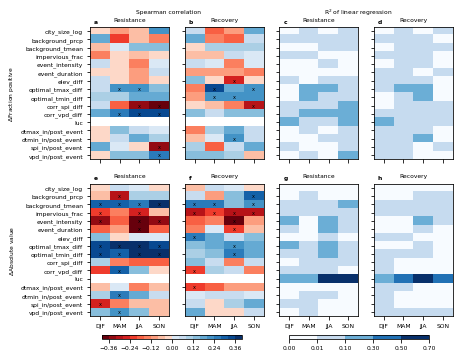

In [33]:
""" Visualize the above Spearman correlation coefficients (with p-values) and R-squared for the predictors.
"""
results = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', 
                                   f'percity_spatial_avg_summary_{fix}_{self.extreme}_fig1_table1{suffix}.csv'), 
                      index_col = [0, 1, 2], header = [0, 1])
for g in ['dtmax_in/post_event', 'dtmin_in/post_event', 'spi_in/post_event', 'vpd_in/post_event']:
    for c in ['Sign', 'Mag']:
        results.loc[('Resistance', c, g), :] = results.loc[('Resistance', c, g.replace('_in/post_event', '_in_event')), :].values
        results.loc[('Recovery', c, g), :] = results.loc[('Recovery', c, g.replace('_in/post_event', '_post_event')), :].values
results = results.drop(['dtmax_in_event', 'dtmax_post_event', 'dtmin_in_event', 'dtmin_post_event', 'spi_in_event', 'spi_post_event', 'vpd_in_event', 'vpd_post_event'], axis = 0, level = 2)


rcParams['font.size'] = 6
rcParams['axes.titlesize'] = 6
lab = 'abcdefghijklmno'


fig, axes = plt.subplots(2, 4, figsize = (6.5, 5.5), sharey = False)
fig.subplots_adjust(hspace = 0.1)


for j, which in enumerate(['Sign', 'Mag']):
    for i, stat in enumerate(['Resistance', 'Recovery']):
        ax = axes[j, i]

        temp = results.loc[(stat, which), 'Rho']
        cf = ax.imshow(temp, cmap = cmap_div(thres = 0.1), aspect = 0.42, 
                       norm = BoundaryNorm(np.linspace(-0.4, 0.4, 21), ncolors = 256, extend = 'neither'))

        temp_p = results.loc[(stat, which), 'Rho_p']
        for a, b in it.product(range(temp_p.shape[0]), range(temp_p.shape[1])):
            if temp_p.iloc[a, b] <= 0.05:
                ax.text(b, a, 'x', fontsize = 5, ha = 'center', va = 'center')

        if i == 0:
            ax.set_yticks(range(temp.shape[0]))
            ax.set_yticklabels(temp.index)
        else:
            ax.set_yticklabels([])
        ax.set_xticks(range(4))
        if j == 1:
            ax.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
        else:
            ax.set_xticklabels([])
        ax.set_title(stat)
        if i == 0:
            if which == 'Sign':
                ax.set_ylabel('$\Delta$Fraction positive')
            else:
                ax.set_ylabel('$\Delta$Absolute value')
        if (j == 0) & (i == 0):
            ax.text(1., 1.1, 'Spearman correlation', transform = ax.transAxes, ha = 'center')
        ax.text(0.05, 1.03, lab[i + j*4], fontweight = 'bold', transform = ax.transAxes)

        if (i + j*2) == 3:
            cax = fig.add_axes([0.15, 0.08, 0.3, 0.01])
            plt.colorbar(cf, cax = cax, orientation = 'horizontal')

        ax = axes[j, i + 2]
        temp = results.loc[(stat, which), 'R2']
        cf = ax.imshow(temp, cmap = 'Blues', 
                       norm = BoundaryNorm([0, 0.01, 0.1, 0.3, 0.5, 0.7], ncolors = 256),
                       aspect = 0.42)

        ax.set_yticks(range(temp.shape[0]))
        ax.set_yticklabels([])
        ax.set_xticks(range(4))
        if j == 1:
            ax.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
        else:
            ax.set_xticklabels([])
        ax.set_title(stat)
        if (j == 0) & (i == 0):
            ax.text(1., 1.1, 'R$^2$ of linear regression', transform = ax.transAxes, ha = 'center')
        ax.text(0.05, 1.03, lab[2 + i + j*4], fontweight = 'bold', transform = ax.transAxes)

        if (i + j*2) == 3:
            cax = fig.add_axes([0.55, 0.08, 0.3, 0.01])
            plt.colorbar(cf, cax = cax, orientation = 'horizontal')

fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
fig.savefig(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_spatial_avg_summary_{fix}_{self.extreme}_fig1_table1{suffix}.png'), dpi = 600., bbox_inches = 'tight', facecolor = 'w')
# plt.close(fig)

In [32]:
""" Boxplots of by land cover differences """
luc_main = predictors.loc[:, luc_list].idxmax(axis = 1)
data = pd.read_csv(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'{self.prefix}_{self.extent}_{self.name}_{self.heat_wave_thres}_{self.hot_and_dry_thres}_{self.extreme}_city_average{suffix}.csv'), 
                index_col = [0,1,2], header = [0, 1])

rcParams['font.size'] = 5.5
rcParams['axes.titlesize'] = 5.5
lab = list('abcdefghijklmnopqrstuvwxyz') + ['aa', 'bb', 'cc', 'dd']

fig, axes = plt.subplots(len(luc_list), 4, figsize = (6.5, 8), sharex = True, sharey = True)
fig.subplots_adjust(hspace = 0., wspace = 0.)
for i, which in enumerate(['Sign', 'Mag']):
    if which == 'Sign':
        varname = '$\Delta$Fraction positive'
    else:
        varname = '$\Delta$Absolute value'
    for j, stat in enumerate(['Resistance', 'Recovery']):
        for k, luc in enumerate(luc_list):
            ax = axes[k, i*2 + j]
            if which == 'Sign':
                y = data.loc[luc_main == luc, (stat, 'frac_pos_urban')] - data.loc[luc_main == luc, (stat, 'frac_pos_rural')]
            else:
                y = data.loc[luc_main == luc, (stat, 'median_abs_urban')] - data.loc[luc_main == luc, (stat, 'median_abs_rural')]
            temp = pd.DataFrame({'x': data.index.get_level_values('season')[luc_main == luc], 'y': y})
            g = sns.boxplot(x = 'x', y = 'y', data = temp, order = ['DJF', 'MAM', 'JJA', 'SON'], ax = ax, whis = [5, 95], showfliers = False, linewidth = 0.5)
            ax.axhline(0., ls = ':', lw = 0.5)

            # calculate the pvalues
            medians = temp.reset_index().set_index(['season', 'use', 'fid'] \
                ).loc[:, 'y'].groupby(['season', 'use']).median().unstack().median(axis = 1)
            pvalues = temp.reset_index().set_index(['season', 'use', 'fid'] \
                ).loc[:, 'y'].groupby(['season', 'use']).apply(lambda ts: wilcoxon(ts).pvalue).unstack().median(axis = 1)
            for l, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
                if pvalues.loc[season] <= 0.05:
                    kwargs = {'bbox': dict(facecolor = 'none', edgecolor = 'k', pad = 1, lw = 0.5)}
                else:
                    kwargs = {}
                ax.text(l, 0.13, f'{medians.loc[season]:.3f}', va = 'center', ha = 'center', **kwargs)

            plt.setp(ax.get_xticklabels(), rotation = 90)
            ax.set_xlabel('')
            if (i == 0) & (j == 0):
                ax.set_ylabel(luc)
            else:
                ax.set_ylabel('')
                ax.tick_params('y', length = 0.)
            if k < (len(luc_list) - 1):
                ax.tick_params('x', length = 0.)
            if k == 0:
                ax.set_title(f'{varname}\n{stat}')

            ax.set_ylim([-0.14, 0.17])
            ax.text(0.05, 0.05, lab[i * 2 + j + k * 4], fontweight = 'bold', transform = ax.transAxes)

fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
fig.savefig(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_spatial_avg_summary_{fix}_{self.extreme}_fig1_S1{suffix}.png'), dpi = 600., bbox_inches = 'tight', facecolor = 'w')
plt.close(fig)


In [4]:
""" Plot the relationship between resistance and recovery, including urban, rural, and urban-rural difference. """
h = pd.HDFStore(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'{self.prefix}_{self.extent}_{self.name}_{self.heat_wave_thres}_{self.hot_and_dry_thres}_{self.extreme}_city_average_events{suffix}.h5'),
                mode = 'r')
data = h.select('data').copy()
data_urban = data.loc['urban', :]
data_rural = data.loc['rural', :]
h.close()

predictors, _ = self._get_predictors(use_gap_to_optimalT)
predictors = predictors[['event_intensity', 'event_duration']]

common_ind = data_urban.index.intersection(predictors.index).intersection(data_rural.index)
data_urban = data_urban.loc[common_ind, :]
data_rural = data_rural.loc[common_ind, :]
predictors = predictors.loc[common_ind, :]
season_ind = common_ind.get_level_values('end').month.map(month_to_season)

In [6]:
lab = 'abcdefghijklmnopqrstuvwxyz'
clist = ['#2596be', '#bea925', '#be4d25', '#9925be']
titles = ['Urban', 'Rural']

rcParams['font.size'] = 6.
rcParams['axes.titlesize'] = 6.

fig = plt.figure(figsize = (6.5, 7.5))
gs = GridSpec(1, 2, figure = fig, wspace = 0.15)
gs_1 = GridSpecFromSubplotSpec(4, 2, subplot_spec = gs[0], wspace = 0.1)
gs_2 = GridSpecFromSubplotSpec(4, 2, subplot_spec = gs[1], wspace = 0.05)
axes = np.empty([4, 4], dtype = object)
for i in range(4):
    for j in range(2):
        axes[i, j] = fig.add_subplot(gs_1[i, j])
        axes[i, j+2] = fig.add_subplot(gs_2[i, j])

for i, data in enumerate([data_urban, data_rural]):
    for s, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        x = data.loc[season_ind == season, 'Resistance']
        y = data.loc[season_ind == season, 'Recovery']

        ax = axes[s, i]
        ax.scatter(x = x, y = y, alpha = 0.2, c = clist[s], s = 3)

        corr = [None] * 3
        pval = [None] * 3
        for u, use in enumerate(['daymet', 'topowx', 'yyz']):
            temp = pd.concat([x.unstack()[use], y.unstack()[use]], axis = 1).dropna(axis = 0)
            corr[u], pval[u] = spearmanr(temp.values[:,0], temp.values[:,1])
        corr = np.median(corr)
        pval = np.median(pval)

        label = f'$r = ${corr:.2f}'
        if pval <= 0.05:
            textweight = 'bold'
        else:
            textweight = 'normal'
        ax.text(0.05, 0.8, label, color = clist[s], fontweight = textweight, transform = ax.transAxes)

        if i != 2:
            ax.set_xlim([-1., 1.4])
            ax.set_ylim([-1., 1.4])
        else:
            ax.set_xlim([-.7, 0.5])
            ax.set_ylim([-.7, 0.5])
            ax.set_yticks([-0.5, 0., 0.5])

        if i == 0:
            ax.set_ylabel(season + '\n' + 'Recovery')
            if s == 0:
                ax.text(1.05, 1.2, 'Resistance-recovery relationship', transform = ax.transAxes, horizontalalignment = 'center')
        elif i == 1:
            ax.set_yticklabels([])
        if s == 3:
            ax.set_xlabel('Resistance')
        else:
            ax.set_xticklabels([])
        if s == 0:
            ax.set_title(titles[i])

        ax.axvline(0., ls = ':', color = 'k', lw = 0.5)
        ax.axhline(0., ls = ':', color = 'k', lw = 0.5)

        n1 = sum((x < 0) & (y < 0))
        ax.text(0.05, 0.02, f'$n=${n1}', transform = ax.transAxes)
        n2 = sum((x < 0) & (y > 0))
        ax.text(0.05, 0.92, f'$n=${n2}', transform = ax.transAxes)
        n3 = sum((x > 0) & (y < 0))
        ax.text(0.7, 0.02, f'$n=${n3}', transform = ax.transAxes)
        n4 = sum((x > 0) & (y > 0))
        ax.text(0.7, 0.92, f'$n=${n4}', transform = ax.transAxes)

        ax.text(0., 1.05, lab[i*4 + s], transform = ax.transAxes, fontweight = 'bold')


# ++: both > 0
# -+: resistance <= 0, but recovered to >= 0
# +-: resistance > 0, but recovered to < 0 (JJA is especially of interest)
# --: both < 0
pct_urban = pd.Series('                 ', index = data_urban.index)
pct_urban.loc[(data_urban['Resistance'] > 0) & (data_urban['Recovery'] >= 0)] = '++'
pct_urban.loc[(data_urban['Resistance'] <= 0) & (data_urban['Recovery'] >= 0)] = '\u2212+'
pct_urban.loc[(data_urban['Resistance'] > 0) & (data_urban['Recovery'] < 0)] = '+\u2212'
pct_urban.loc[(data_urban['Resistance'] <= 0) & (data_urban['Recovery'] < 0)] = '\u2212\u2212'

pct_rural = pd.Series('                 ', index = data_rural.index)
pct_rural.loc[(data_rural['Resistance'] > 0) & (data_rural['Recovery'] >= 0)] = '++'
pct_rural.loc[(data_rural['Resistance'] <= 0) & (data_rural['Recovery'] >= 0)] = '\u2212+'
pct_rural.loc[(data_rural['Resistance'] > 0) & (data_rural['Recovery'] < 0)] = '+\u2212'
pct_rural.loc[(data_rural['Resistance'] <= 0) & (data_rural['Recovery'] < 0)] = '\u2212\u2212'

for i, pct_loc in enumerate([pct_urban, pct_rural]):
    for s, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
        ax = axes[s, i+2]

        x = np.linspace(0.5, 9.5, 10)
        x_mid = [f'{xx:.0f}' for xx in 0.5 * (x[1:] + x[:-1])]
        y = np.linspace(-0.25, 5.25, 12)
        y_mid = [f'{yy:.0f}' for yy in 0.5 * (y[1:] + y[:-1])]
        z = np.full((len(y)-1, len(x)-1), fill_value = np.nan)
        for a, b in it.product(range(len(x)-1), range(len(y)-1)):
            filt = (predictors['event_duration' ].values >= x[a]) & (predictors['event_duration' ].values < x[a+1]) & \
                    (predictors['event_intensity'].values >= y[b]) & (predictors['event_intensity'].values < y[b+1]) & \
                    (season_ind == season)
            z[b, a] = np.nanmean(pct_loc.values[filt] == '+\u2212') * 100.
        cf = ax.imshow(z[::-1, :], cmap = 'Greys', vmin = 0., vmax = 100.)
        ax.set_xticks(range(0, len(x_mid), 1))
        ax.set_xticklabels(x_mid)
        ax.set_yticks(range(0, len(y_mid), 2))
        ax.set_yticklabels(y_mid[::-1][::2])
        ax.text(0., 1.05, lab[i*4 + s + 8], transform = ax.transAxes, fontweight = 'bold')
        ax.axvline(3, ls = ':', color = 'r', lw = 0.5)
        ax.axhline(6, ls = ':', color = 'r', lw = 0.5)

        if i == 0:
            ax.set_ylabel(f'Intensity ($^o$C)')
            if s == 0:
                ax.text(1.05, 1.2, 'Percent +\u2212 events', transform = ax.transAxes, horizontalalignment = 'center')
        elif i == 1:
            ax.set_yticklabels([])
        if s == 3:
            ax.set_xlabel('Duration (months)')
        else:
            ax.set_xticklabels([])
        if s == 0:
            ax.set_title(titles[i])

cax = fig.add_axes([0.52, 0.05, 0.38, 0.01])
plt.colorbar(cf, cax = cax, orientation = 'horizontal')

fix = Setup().format_prefix().replace(f'{Setup().use}_', '')
fig.savefig(os.path.join(path_out, 'measures', 'regression_per_pixel', 'summary', f'percity_spatial_avg_summary_{fix}_{self.extreme}_corr.png'), dpi = 600., bbox_inches = 'tight', facecolor = 'w')
plt.close(fig)